# Gas Fees / Compute Units Used in a block range

## Ethereum

In [3]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
ETHEREUM_RPC_URL = "YOUR_ETHEREUM_RPC_URL"
start_block_number = 20871164  # Replace with the current block number or the desired starting block
num_blocks_to_check = 10

In [4]:
def get_eth_block_gas_used(block_number, endpoint_url):
    gas_limit = 30000000
    headers = {
        "Content-Type": "application/json"
    }

    # The payload to call the eth_getBlockByNumber method
    payload = {
        "jsonrpc": "2.0",
        "method": "eth_getBlockByNumber",
        "params": [hex(block_number), False],  # False for no transaction details
        "id": 1
    }

    response = requests.post(endpoint_url, json=payload, headers=headers)

    if response.status_code == 200:
        result = response.json().get("result", {})
        gas_used = int(result.get("gasUsed", "0x0"), 16)  # Convert from hex to int
        return round(((gas_used/gas_limit)*100), 2)
    else:
        raise Exception(f"Error fetching block data: {response.status_code} - {response.text}")

In [8]:
def plot_gas_used_for_blocks(start_block, num_blocks):
    gas_used_values = []
    block_numbers = []
    
    # Iterate over the last `num_blocks` blocks
    for i in range(num_blocks):
        block_number = start_block - i
        gas_used = get_eth_block_gas_used(block_number, ETHEREUM_RPC_URL)
        gas_used_values.append(gas_used)
        block_numbers.append(block_number)

    # Create a Pandas DataFrame
    df = pd.DataFrame({
        'Block Number': block_numbers,
        'Gas Used': gas_used_values
    })

    # Plotting the gas used using Pandas (which integrates with matplotlib)
    ax = df.plot(x='Block Number', y='Gas Used', kind='line', marker='o', figsize=(10, 6))

    # Set full block numbers as x-ticks, ensuring full display
    ax.set_xticks(block_numbers)
    ax.set_xticklabels(block_numbers, rotation=45, ha='right')  # Rotate for readability

    plt.title(f"Gas used per block as a % of Gas Limit")
    plt.xlabel("Block Number")
    plt.ylabel("Gas Used") 
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make sure labels fit well
    plt.show()

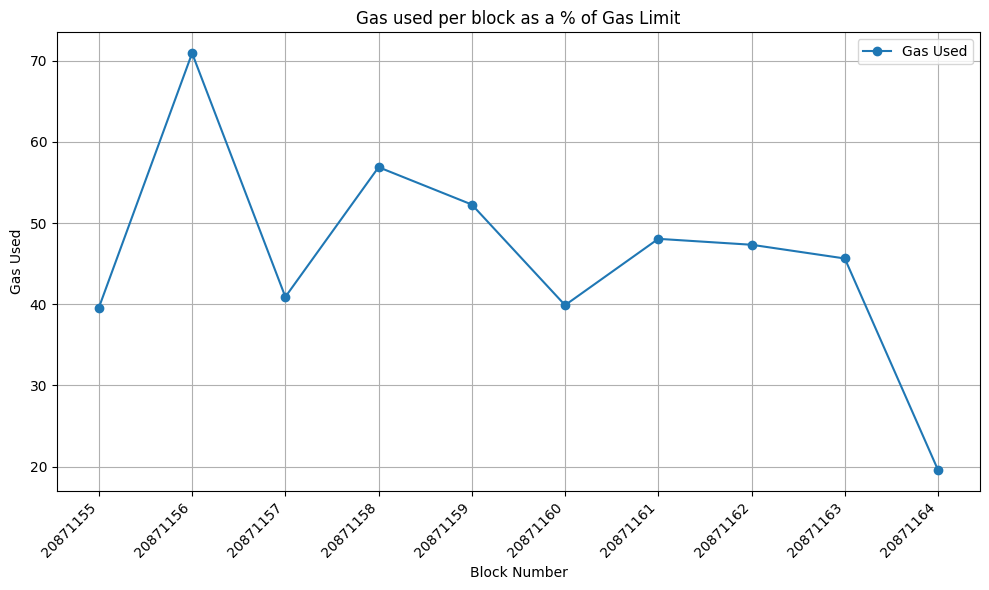

In [9]:
try:
    plot_gas_used_for_blocks(start_block_number, num_blocks_to_check)
except Exception as e:
    print(e)

## Solana

In [13]:
SOLANA_RPC_URL = 'YOUR_SOLANA_RPC_URL'

In [84]:
def get_solana_block_compute_units(block_number, endpoint_url):
    headers = {
        "Content-Type": "application/json"
    }

    # The payload to call the getConfirmedBlock method
    payload = {
        "jsonrpc": "2.0",
        "method": "getBlock",
        "params": [block_number, {"encoding": "json", "transactionDetails": "full",  "maxSupportedTransactionVersion":0, "rewards": False}],
        "id": 1
    }

    response = requests.post(endpoint_url, json=payload, headers=headers)

    if response.status_code == 200:
        block_data = response.json().get("result", {})
        transactions = block_data.get("transactions", [])
        total_compute_units = 0


        # Iterate over all transactions in the block
        for tx in transactions:
            meta = tx.get("meta", {})
            compute_units = meta.get("computeUnitsConsumed", 0)
            total_compute_units += compute_units

        return total_compute_units
    else:
        raise Exception(f"Error fetching block data: {response.status_code} - {response.text}")

In [11]:
def compute_units_for_block_range(start_block, num_blocks, endpoint_url):
    compute_unit_limit = 48000000
    block_compute_units = {}

    for i in range(num_blocks):
        block_number = start_block - i
        try:
            compute_units = get_solana_block_compute_units(block_number, SOLANA_RPC_URL)
            block_compute_units[block_number] = round(((compute_units / compute_unit_limit) * 100),2)
        except Exception as e:
            print(f"Error fetching data for block {block_number}: {e}")
    
    return block_compute_units

In [89]:
def plot_compute_units(block_compute_units):
    # Convert the block data into a Pandas DataFrame
    df = pd.DataFrame(list(block_compute_units.items()), columns=['Block Number', 'Compute Units'])

    # Plot the compute units per block using Pandas
    ax = df.plot(x='Block Number', y='Compute Units', kind='line', marker='o', figsize=(10, 6))

    # Set x-ticks for all block numbers
    ax.set_xticks(df['Block Number'])
    ax.set_xticklabels(df['Block Number'], rotation=45, ha='right')  # Rotate for readability

    plt.title("Compute Units per Block as a % of Compute Unit Limit")
    plt.xlabel("Block Number")
    plt.ylabel("Compute Units")
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to ensure labels fit well
    plt.show()


Block 293092462: 70.25% compute units used
Block 293092461: 88.02% compute units used
Block 293092460: 85.49% compute units used
Block 293092459: 89.25% compute units used
Block 293092458: 91.28% compute units used
Block 293092457: 87.88% compute units used
Block 293092456: 84.79% compute units used
Block 293092455: 93.21% compute units used
Block 293092454: 88.02% compute units used
Block 293092453: 97.13% compute units used


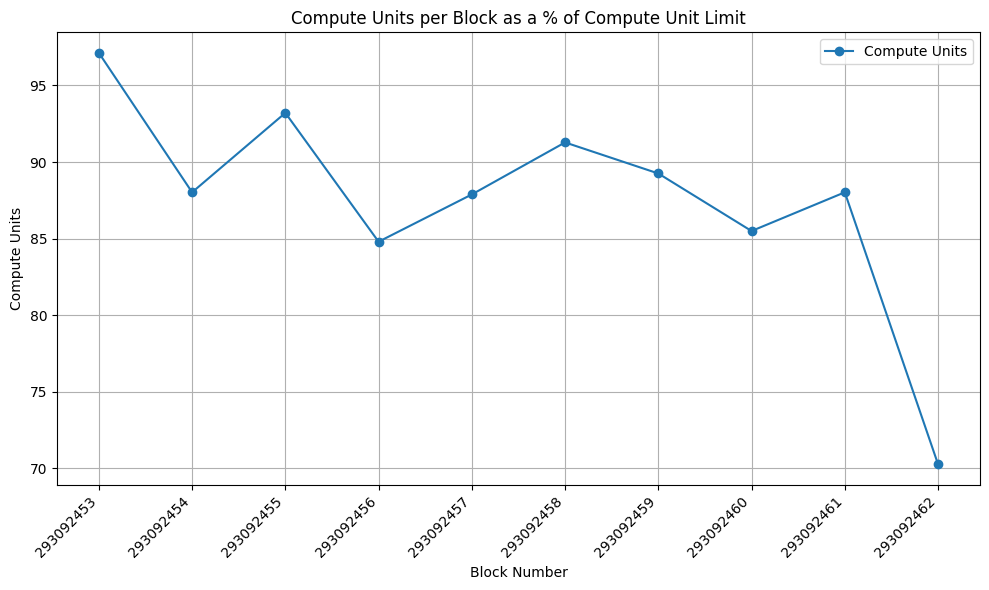

In [91]:
start_block_number = 293092462  # Replace with the current block number or the desired starting block
num_blocks_to_check = 10

try:
    block_compute_units = compute_units_for_block_range(start_block_number, num_blocks_to_check)
    
    # Display the compute units for each block
    for block_number, compute_units in block_compute_units.items():
        print(f"Block {block_number}: {compute_units}% compute units used")
    
    # Plot the compute units per block
    plot_compute_units(block_compute_units)

except Exception as e:
    print(e)